# LSTM Sentiment Analysis for Bussiness Performances Review

## Download and Import modules
This code snippet includes several import statements and libraries used for text preprocessing and preparing data for a machine learning model. It imports numpy and pandas for data manipulation, nltk and stopwords for text processing, Sastrawi for stemming, re and string for text cleaning, multiprocessing for parallel processing, csv for handling CSV files, tensorflow for building and training the machine learning model, sklearn for label encoding, and Tokenizer and pad_sequences from `tensorflow.keras.preprocessing.text` for tokenizing and padding sequences.



In [1]:
!pip install Sastrawi

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 209.7/209.7 kB 5.0 MB/s eta 0:00:00


In [2]:
import numpy as np
import pandas as pd
import nltk
from nltk.corpus import stopwords
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
import re
import string
import multiprocessing
import csv
import tensorflow as tf
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [3]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

## Load Files
This code snippet below mounts the Google Drive to the Colab notebook and copies two CSV files (olshop_negative.csv and olshop_positive.csv) from the specified paths in the Google Drive to the /content directory in the Colab environment. It utilizes the google.colab library for mounting the drive and the shutil library for file copying. The code ensures that the drive is forcefully remounted and performs the copy operation using a list comprehension.

In [6]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [7]:
import shutil

paths = ['/content/drive/MyDrive/Review/olshop_negative.csv', '/content/drive/MyDrive/Review/olshop_positive.csv']

[shutil.copy(i, '/content') for i in paths]

['/content/olshop_negative.csv', '/content/olshop_positive.csv']

## Define Preprocessing and File Parsing Function

These code below defines a text preprocessing function that takes a sentence as input and performs several preprocessing steps. It uses the Sastrawi library for stemming the words in the sentence, converts the sentence to lowercase, removes numbers, punctuation, and whitespace, and finally removes stopwords using a predefined set of Indonesian stopwords. The function returns the preprocessed sentence.

In [8]:
#Text preprocessing (reproducible)
stemmer = StemmerFactory().create_stemmer()
listStopword =  set(stopwords.words('indonesian'))

def text_preprocessing(sentence):
  
  #Stemming using Sastrawi
  sentence   = stemmer.stem(sentence)

  #lowering case
  sentence = sentence.lower()

  #remove number
  sentence = re.sub(r"\d+", "", sentence)

  #remove punctuation and whitespace
  sentence = sentence.translate(str.maketrans("","", string.punctuation))
  sentence = sentence.strip()

  #remove stopwords
  words = sentence.split()
  no_words = [w for w in words if w not in listStopword]
  sentence = " ".join(no_words)

  return sentence

These code snippets below defines a function for parsing a CSV file containing reviews. The function takes the file path and a sentiment value as input. It reads the CSV file, skips the header row, and iterates over the rows. If a row has a length different from the specified standardized length, it is skipped. The function extracts the sentence from the row, applies a text preprocessing function to the sentence, and appends it to a list of sentences. It also creates a list of labels based on the provided sentiment value. The function returns a list of tuples, where each tuple contains a preprocessed sentence and its corresponding label.

In [9]:
# Parse csv review
def parse_csv(filePath, sentiment):
  sentences = []

  with open(filePath, 'r') as csvfile:
    reader = csv.reader(csvfile, delimiter='|')
    next(reader)  # Skip the header row if present
    
    standardized_length = 4  # Specify the desired length of rows

    for row in reader:
      if len(row) != standardized_length:
        continue  # Skip rows with non-standardized length
      sentence = row[2]
      sentence = text_preprocessing(sentence)  # Apply text preprocessing function
      sentences.append(sentence)
  labels = [sentiment] * len(sentences)
  return list(zip(sentences, labels))

## Parse and Process Negative Review

In [10]:
#Lets parse negative review
neg_dataset = parse_csv('/content/olshop_negative.csv', sentiment='negative')

In [11]:
print(f"There are {len(neg_dataset)} sentences in the dataset.\n")
print("First sentence:\n{}\n".format(neg_dataset[0][0]))
print(f"First sentence has {len(neg_dataset[0][0].split())} words (after removing stopwords).\n")
print(f"There are {len([label for _, label in neg_dataset])} labels in the dataset.\n")
print("The first 5 labels are:{}".format([label for _, label in neg_dataset[:5]]))

There are 1944 sentences in the dataset.

First sentence:
belanja bhineka ogah ogah dasar review bhineka point ya iklan adsense cuman berani bayar perak login langsung blokir iklan adsense bhineka curcol bentar toko harga situ sungguh kecewa update alias harga beda saing toko merchan ragu dengar komentar transaksi bhineka ribet bhineka aja ribet pa merchan host bhineka ribet kuadrat moga bhineka bangkit saing toko toko online malu ah web doang kualitas cetek ngak beli ni bhineka toko halaman web kalah enterkomputer rakit nonokomputer

First sentence has 74 words (after removing stopwords).

There are 1944 labels in the dataset.

The first 5 labels are:['negative', 'negative', 'negative', 'negative', 'negative']


## Parse and Process Positive Review

In [12]:
pos_dataset = parse_csv('/content/olshop_positive.csv', sentiment='positive')

In [13]:
print(f"There are {len(pos_dataset)} sentences in the dataset.\n")
print("First sentence:\n{}\n".format(pos_dataset[0][0]))
print(f"First sentence has {len(pos_dataset[0][0].split())} words (after removing stopwords).\n")
print(f"There are {len([label for _, label in pos_dataset])} labels in the dataset.\n")
print("The first 5 labels are:{}".format([label for _, label in pos_dataset[:5]]))

There are 10116 sentences in the dataset.

First sentence:
moga bhinneka com adain kuis kalo survey hadiah biar gampang menang

First sentence has 11 words (after removing stopwords).

There are 10116 labels in the dataset.

The first 5 labels are:['positive', 'positive', 'positive', 'positive', 'positive']


## Unite and Shuffle The Aggregated Dataset

In [33]:
BUFFER_SIZE = 15000

agg_dataset = tf.data.Dataset.from_tensor_slices(neg_dataset + pos_dataset)

# Shuffle the dataset
agg_dataset = agg_dataset.shuffle(BUFFER_SIZE)

# Prefetch the data
agg_dataset = agg_dataset.prefetch(1)

In [34]:
print(len(agg_dataset))

12060


## Split The Dataset into Training and Validation

In [35]:
def split_train_val(dataset, train_split):
  
  # Unzip the dataset into sentences and labels
  all_sentences, all_labels = zip(*dataset)

  # Convert EagerTensor objects to regular Python lists
  all_sentences = [str(sentence.numpy(), 'utf-8') for sentence in all_sentences]
  all_labels = [str(label.numpy(), 'utf-8') for label in all_labels]

  # Encode labels
  encoder = LabelEncoder()
  all_labels = encoder.fit_transform(all_labels)

  split = int(len(all_sentences)*train_split)

  train_sentences = all_sentences[:split]
  train_labels = all_labels[:split]

  val_sentences = all_sentences[split:]
  val_labels = all_labels[split:]

  return train_sentences, val_sentences, train_labels, val_labels

In [36]:
TRAINING_SPLIT = 0.85
train_sentences, val_sentences, train_labels, val_labels = split_train_val(agg_dataset, train_split=TRAINING_SPLIT)

In [37]:
print(f"There are {len(train_sentences)} sentences for training.\n")
print(f"There are {len(train_labels)} labels for training.\n")
print(f"There are {len(val_sentences)} sentences for validation.\n")
print(f"There are {len(val_labels)} labels for validation.{val_labels[:5]}")

There are 10251 sentences for training.

There are 10251 labels for training.

There are 1809 sentences for validation.

There are 1809 labels for validation.[1 0 1 1 1]


## Tokenization and Sequencing

In [38]:
NUM_WORDS = 20000
EMBEDDING_DIM = 16
MAXLEN = max([len(sentence) for sentence in train_sentences+val_sentences])
PADDING = 'post'
OOV_TOKEN = "<OOV>"

In [39]:
print(MAXLEN)

2482


In [40]:
def tokenizer_(sentences, num_words, oov_token):
    # Instantiate the Tokenizer class, passing in the correct values for num_words and oov_token
    tokenizer = Tokenizer(num_words = num_words, oov_token=oov_token)
    
    # Fit the tokenizer to the training sentences
    tokenizer.fit_on_texts(train_sentences)

    return tokenizer


In [41]:
tokenizer = tokenizer_(train_sentences, NUM_WORDS, OOV_TOKEN)
word_index = tokenizer.word_index

print(f"Vocabulary contains {len(word_index)} words\n")
print("<OOV> token included in vocabulary" if "<OOV>" in word_index else "<OOV> token NOT included in vocabulary")

Vocabulary contains 12287 words

<OOV> token included in vocabulary


In [42]:
def seq_and_pad(sentences, tokenizer, padding, maxlen):
    # Convert sentences to sequences
    sequences = tokenizer.texts_to_sequences(sentences)
    
    # Pad the sequences using the correct padding and maxlen
    padded_sequences = pad_sequences(sequences, padding=padding, maxlen=maxlen)
    
    return padded_sequences

In [43]:
padded_train = seq_and_pad(train_sentences, tokenizer, PADDING, MAXLEN)
padded_val = seq_and_pad(val_sentences, tokenizer, PADDING, MAXLEN)

print(f"Padded training sequences have shape: {padded_train.shape}\n")
print(f"Padded validation sequences have shape: {padded_val.shape}")

Padded training sequences have shape: (10251, 2482)

Padded validation sequences have shape: (1809, 2482)


## Create Callbacks

In [44]:
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('val_accuracy')>0.900):
      print("\nReached 90% accuracy so cancelling training!")
      self.model.stop_training = True

## Create LSTM Model

In [45]:
def create_model(vocab_size, embedding_dim, maxlen):
    model = tf.keras.Sequential([ 
        tf.keras.layers.Embedding(vocab_size+1, embedding_dim, input_length=maxlen), 
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(150)),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(32, activation='relu'),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    
    accuracy = tf.keras.metrics.BinaryAccuracy(name='accuracy')
    precision = tf.keras.metrics.Precision(name='precision')

    model.compile(loss='binary_crossentropy',
                  optimizer='rmsprop',
                  metrics=[accuracy, precision]) 
    
    return model

## Training the Model

In [47]:
model = create_model(NUM_WORDS, EMBEDDING_DIM, MAXLEN)

history = model.fit(padded_train, 
                    train_labels, 
                    epochs=100, 
                    validation_data=(padded_val, val_labels),
                    verbose=1,
                    callbacks=myCallback())

Epoch 1/100
321/321 [==============================] - 2999s 9s/step - loss: 0.3039 - accuracy: 0.8804 - precision: 0.9043 - val_loss: 0.2290 - val_accuracy: 0.8917 - val_precision: 0.9474
Epoch 2/100
321/321 [==============================] - ETA: 0s - loss: 0.2187 - accuracy: 0.9148 - precision: 0.9464
Reached 90% accuracy so cancelling training!
321/321 [==============================] - 2977s 9s/step - loss: 0.2187 - accuracy: 0.9148 - precision: 0.9464 - val_loss: 0.2266 - val_accuracy: 0.9027 - val_precision: 0.9320


## Model Evaluation

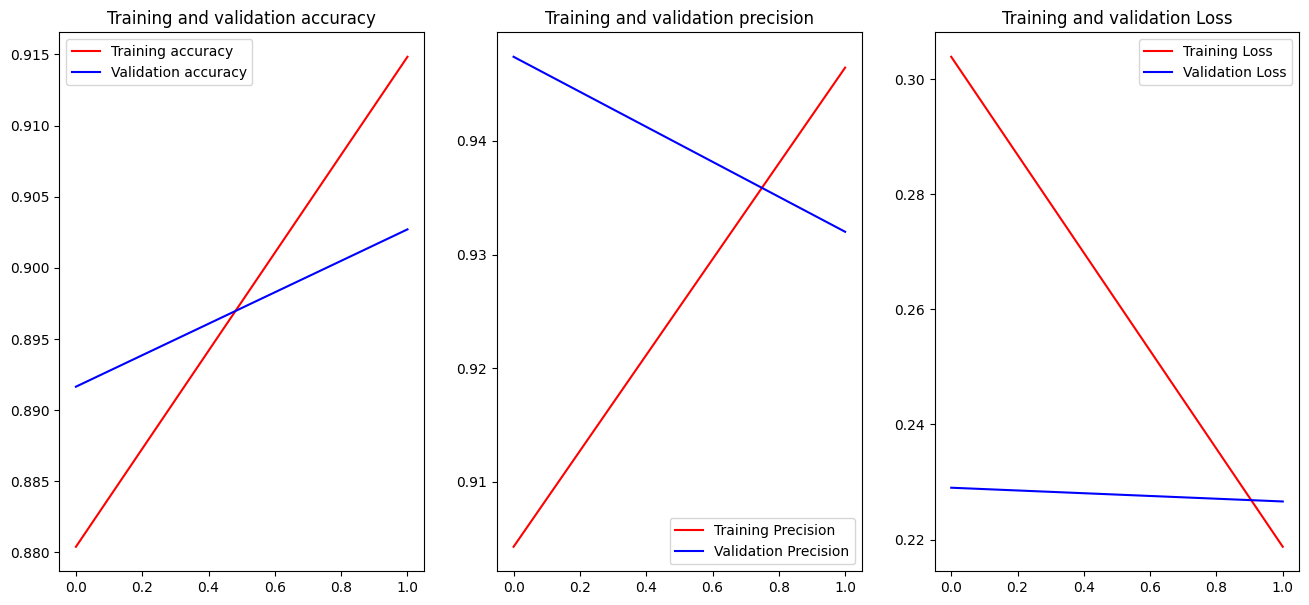

In [48]:
import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
precision = history.history['precision']
val_precision = history.history['val_precision']

epochs = range(len(acc))

# Create a subplot with two plots stacked vertically
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(16, 7))

# Plot the first plot on the left
ax1.plot(epochs, acc, 'r', label='Training accuracy')
ax1.plot(epochs, val_acc, 'b', label='Validation accuracy')
ax1.set_title('Training and validation accuracy')
ax1.legend(loc=0)

# Plot the second plot 
ax2.plot(epochs, precision, 'r', label='Training Precision')
ax2.plot(epochs, val_precision, 'b', label='Validation Precision')
ax2.set_title('Training and validation precision')
ax2.legend(loc=0)

# Plot the third plot on the right
ax3.plot(epochs, loss, 'r', label='Training Loss')
ax3.plot(epochs, val_loss, 'b', label='Validation Loss')
ax3.set_title('Training and validation Loss')
ax3.legend(loc=0)

# Show the plot
plt.show()

## Testing

In [84]:
text_test = ['Tidak bisa dipercaya, sangat menyesal belanja di Bhinneka.com. Barangnya tidak ori jadi gampang rusak']
#text_test = [text_preprocessing(text_test)]
padded_test = seq_and_pad(text_test, tokenizer, PADDING, MAXLEN)

model.predict(padded_test)
# should be interpret as negative comment

1/1 [==============================] - 0s 302ms/step


array([[0.63775796]], dtype=float32)

## Save the model

In [49]:
saved_model_path = "./content/LSTM-sentiment-model.h5"

model.save(saved_model_path)

dest_path = '/content/drive/MyDrive/Review'
shutil.copyfile(saved_model_path, dest_path + '/LSTM-sentiment-model.h5')


'/content/drive/MyDrive/Review/LSTM-sentiment-model.h5'

## Run JSON Converter

In [50]:
!pip install tensorflowjs

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.1/85.1 kB 6.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 189.9/189.9 kB 19.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.4/16.4 MB 57.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.9/40.9 kB 4.1 MB/s eta 0:00:00
  Attempting uninstall: packaging
    Found existing installation: packaging 23.1
    Uninstalling packaging-23.1:
      Successfully uninstalled packaging-23.1
  Attempting uninstall: flax
    Found existing installation: flax 0.6.9
    Uninstalling flax-0.6.9:
      Successfully uninstalled flax-0.6.9
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
statsmodels 0.13.5 requires packaging>=21.3, but you have packaging 20.9 which is incompatible.
xar

In [51]:
!tensorflowjs_converter --input_format=keras {saved_model_path} ./

2023-05-22 05:51:00.471631: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [52]:
shutil.copyfile('/content/group1-shard1of1.bin', dest_path + '/group1-shard1of1.bin')
shutil.copyfile('/content/model.json', dest_path + '/model.json')

'/content/drive/MyDrive/Review/model.json'

## Covert to TFLite

In [56]:
import pathlib
export_dir = './content/saved_model/'
tf.saved_model.save(model, export_dir)

converter = tf.lite.TFLiteConverter.from_saved_model(export_dir)

# Set the optimizations
converter.optimizations = [tf.lite.Optimize.DEFAULT]

# Set supported ops to include SELECT_TF_OPS
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS, tf.lite.OpsSet.SELECT_TF_OPS]

# Disable lowering tensor list ops
converter._experimental_lower_tensor_list_ops = False

# Invoke the converter to generate the TFLite model
tflite_model = converter.convert()

tflite_model_file = pathlib.Path('./model.tflite')
tflite_model_file.write_bytes(tflite_model)


568248